# Regularization（正则化）

如果数据集不够大，那么因为深度学习模型的复杂灵活性和容量都比较大，所以它非常容易过拟合。过拟合会导致训练集准确率比较高，但是它泛化能力非常弱，也就是说学习到的模型对新的没见过数据预测误差会非常大。

下面将会学习：深度学习模型中正则化的使用。

# 一、导入相关库

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
from testCases import *
import init_utils   #第一部分，初始化
import reg_utils    #第二部分，正则化
import gc_utils     #第三部分，梯度校验
#%matplotlib inline #如果你使用的是Jupyter Notebook，请取消注释。
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**问题描述**：假设你现在是一个AI专家，你需要设计一个模型，可以用于推荐在足球场中守门员将球发至哪个位置可以让本队的球员抢到球的可能性更大。说白了，实际上就是一个二分类，一半是己方抢到球，一半就是对方抢到球，我们来看一下这个图：

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **图 1** </u>: **足球场**<br> 守门员将球踢到空中，每支球队的球员都用头撞击球</center></caption>


下面提供了法国过去10场比赛的以下2D数据集。

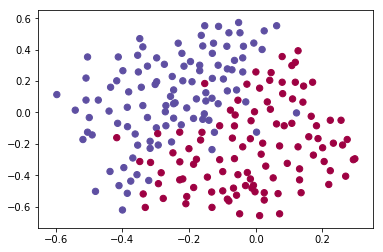

In [2]:
train_X, train_Y, test_X, test_Y = reg_utils.load_2D_dataset(is_plot=True)

 每一个点代表球落下的可能的位置，蓝色代表己方的球员会抢到球，红色代表对手的球员会抢到球，我们要做的就是使用模型来画出一条线，来找到适合我方球员能抢到球的位置。 
我们要做以下三件事，来对比出不同的模型的优劣：

- 1. 不使用正则化

- 2. 使用正则化 

   2.1 使用L2正则化 
   
   2.2 使用随机节点删除
   
我们来看一下我们的模型：

- 正则化模式 - 将lambd输入设置为非零值。 我们使用“lambd”而不是“lambda”，因为“lambda”是Python中的保留关键字。
- 随机删除节点 - 将keep_prob设置为小于1的值
# 二、建立模型

In [4]:
def model(X,Y,learning_rate=0.3,num_iterations=30000,print_cost=True,is_plot=True,lambd=0,keep_prob=1):
    """
    实现一个三层的神经网络：LINEAR ->RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID

    参数：
        X - 输入的数据，维度为(2, 要训练/测试的数量)
        Y - 标签，【0(蓝色) | 1(红色)】，维度为(1，对应的是输入的数据的标签)
        learning_rate - 学习速率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每迭代10000次打印一次，但是每1000次记录一个成本值
        is_polt - 是否绘制梯度下降的曲线图
        lambd - 正则化的超参数，实数
        keep_prob - 随机保留节点的概率
    返回
        parameters - 学习后的参数
    """
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0],20,3,1]

    #初始化参数
    parameters = reg_utils.initialize_parameters(layers_dims) # 用的是Xavier初始化，感觉不好，应该用He初始化

    #开始学习
    for i in range(0,num_iterations):
        #前向传播
        ##是否随机删除节点
        if keep_prob == 1:
            ###不随机删除节点
            a3 , cache = reg_utils.forward_propagation(X,parameters)
        elif keep_prob < 1:
            ###随机删除节点
            a3 , cache = forward_propagation_with_dropout(X,parameters,keep_prob)
        else:
            print("keep_prob参数错误！程序退出。")
            exit

        #计算成本
        ## 是否使用二范数
        if lambd == 0:
            ###不使用L2正则化
            cost = reg_utils.compute_cost(a3,Y)
        else:
            ###使用L2正则化
            cost = compute_cost_with_regularization(a3,Y,parameters,lambd)

        #反向传播
        ##可以同时使用L2正则化和随机删除节点，但是本次实验不同时使用。
        assert(lambd == 0  or keep_prob ==1)

        ##两个参数的使用情况
        if (lambd == 0 and keep_prob == 1):
            ### 不使用L2正则化和不使用随机删除节点
            grads = reg_utils.backward_propagation(X,Y,cache)
        elif lambd != 0:
            ### 使用L2正则化，不使用随机删除节点
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            ### 使用随机删除节点，不使用L2正则化
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)

        #更新参数
        parameters = reg_utils.update_parameters(parameters, grads, learning_rate)

        #记录并打印成本
        if i % 1000 == 0:
            ## 记录成本
            costs.append(cost)
            if (print_cost and i % 10000 == 0):
                #打印成本
                print("第" + str(i) + "次迭代，成本值为：" + str(cost))

    #是否绘制成本曲线图
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (x1,000)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    #返回学习后的参数
    return parameters

# 三、不使用正则化

第0次迭代，成本值为：0.6557412523481002
第10000次迭代，成本值为：0.16329987525724188
第20000次迭代，成本值为：0.1385164242325138


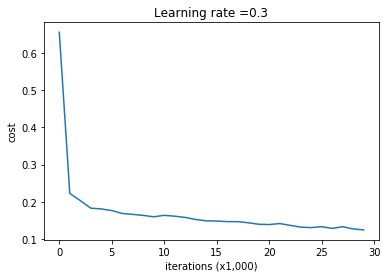

训练集:
Accuracy: 0.9478672985781991
测试集:
Accuracy: 0.915


In [5]:
parameters = model(train_X, train_Y,is_plot=True)
print("训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

我们可以看到，对于训练集，精确度为94%；而对于测试集，精确度为91.5%。接下来，我们将分割曲线画出来：

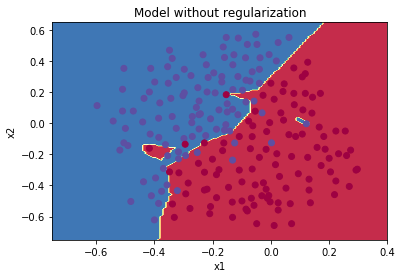

In [6]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, np.squeeze(train_Y))

从图中可以看出，在无正则化时，分割曲线有了明显的过拟合特性。接下来，我们使用L2正则化。

# 四、仅使用L2正则化

避免过度拟合的标准方法称为L2正则化，它包括适当修改你的成本函数，我们从原来的成本函数(1)到现在的函数(2)：
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

计算$\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$  的代码为 :`np.sum(np.square(Wl))`


需要注意的是在前向传播中我们对 $W^{[1]}$ 、$W^{[2]}$ 和$W^{[3]}$这三个项进行操作，将这三个项相加并乘以$ \frac{1}{m} \frac{\lambda}{2} $。在后向传播中，使用$\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$计算梯度。我们下面就开始写相关的函数：

In [7]:
def compute_cost_with_regularization(A3,Y,parameters,lambd):
    """
    实现公式2的L2正则化计算成本

    参数：
        A3 - 正向传播的输出结果，维度为（输出节点数量，训练/测试的数量）
        Y - 标签向量，与数据一一对应，维度为(输出节点数量，训练/测试的数量)
        parameters - 包含模型学习后的参数的字典
    返回：
        cost - 使用公式2计算出来的正则化损失的值

    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    cross_entropy_cost = reg_utils.compute_cost(A3,Y)

    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2))  + np.sum(np.square(W3))) / (2 * m)

    cost = cross_entropy_cost + L2_regularization_cost

    return cost

#当然，因为改变了成本函数，我们也必须改变向后传播的函数， 所有的梯度都必须根据这个新的成本值来计算。

def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    实现我们添加了L2正则化的模型的后向传播。

    参数：
        X - 输入数据集，维度为（输入节点数量，数据集里面的数量）
        Y - 标签，维度为（输出节点数量，数据集里面的数量）
        cache - 来自forward_propagation（）的cache输出
        lambd - regularization超参数，实数

    返回：
        gradients - 一个包含了每个参数、激活值和预激活值变量的梯度的字典
    """

    m = X.shape[1]

    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y

    dW3 = (1 / m) * np.dot(dZ3,A2.T) + ((lambd * W3) / m )
    db3 = (1 / m) * np.sum(dZ3,axis=1,keepdims=True)

    dA2 = np.dot(W3.T,dZ3)
    dZ2 = np.multiply(dA2,np.int64(A2 > 0))
    dW2 = (1 / m) * np.dot(dZ2,A1.T) + ((lambd * W2) / m)
    db2 = (1 / m) * np.sum(dZ2,axis=1,keepdims=True)

    dA1 = np.dot(W2.T,dZ2)
    dZ1 = np.multiply(dA1,np.int64(A1 > 0))
    dW1 = (1 / m) * np.dot(dZ1,X.T) + ((lambd * W1) / m)
    db1 = (1 / m) * np.sum(dZ1,axis=1,keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

测试一下计算正则化的成本函数是否正确：

In [11]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


测试一下正则化的反向传播函数一样

In [12]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


我们来直接放到模型中跑一下：

第0次迭代，成本值为：0.6974484493131264
第10000次迭代，成本值为：0.2684918873282239
第20000次迭代，成本值为：0.26809163371273004


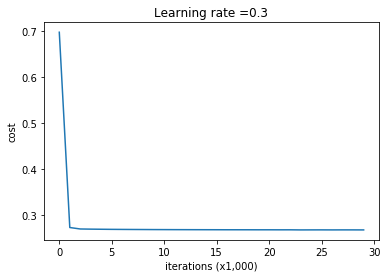

使用正则化，训练集:
Accuracy: 0.9383886255924171
使用正则化，测试集:
Accuracy: 0.93


In [8]:
parameters = model(train_X, train_Y, lambd=0.7,is_plot=True)
print("使用正则化，训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("使用正则化，测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

我们来看一下分类的结果吧~

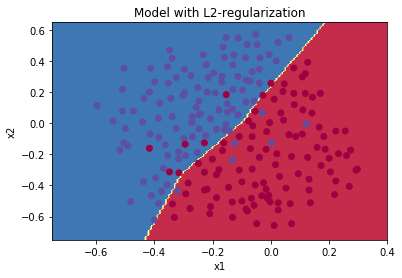

In [9]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, np.squeeze(train_Y))

λ的值是可以使用开发集调整时的超参数。L2正则化会使决策边界更加平滑。如果λ太大，也可能会“过度平滑”，从而导致模型高偏差。L2正则化实际上在做什么？L2正则化依赖于较小权重的模型比具有较大权重的模型更简单这样的假设，因此，通过削减成本函数中权重的平方值，可以将所有权重值逐渐改变到到较小的值。权值数值高的话会有更平滑的模型，其中输入变化时输出变化更慢，但是你需要花费更多的时间。L2正则化对以下内容有影响：

- 成本计算        ： 正则化的计算需要添加到成本函数中
- 反向传播功能      ：在权重矩阵方面，梯度计算时也要依据正则化来做出相应的计算
- 重量变小（“重量衰减”) ：权重被逐渐改变到较小的值。

# 五、仅使用dropout正则化（随机删除节点）

  最后，我们使用Dropout来进行正则化，Dropout的原理就是每次迭代过程中随机将其中的一些节点失效。当我们关闭一些节点时，我们实际上修改了我们的模型。背后的想法是，在每次迭代时，我们都会训练一个只使用一部分神经元的不同模型。随着迭代次数的增加，我们的模型的节点会对其他特定节点的激活变得不那么敏感，因为其他节点可能在任何时候会失效。我们通过下面的两个视频来了解什么是dropout。
  
  
<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 


<center>
<video width="620" height="440" src="images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> 图 2 </u>: 在第2层上使用Drop-out . <br>在每次迭代中，该层的每一个神经元均有 $1 - keep\_prob$ 的概率被关掉/舍弃，即有 $keep\_prob$ (50% here)的概率保持激活状态。丢弃掉的神经元在训练中没有任何贡献或作用，即不参与训练中的前向传播和反向传播。</center></caption>

<center>
<video width="620" height="440" src="images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> <u> 图 3 </u>: 在第1层和第3层上使用Drop-out. <br> 第 $1^{st}$ 层: 丢弃了 40% 的神经元。  第 $3^{rd}$ 层: 丢弃了 20% 的神经元。</center></caption>

## 1 - Forward propagation with dropout

**内容**: 实现带 dropout的前向传播. 神经网络为3层，对第1、2个隐藏层实施dropout，不能对输入层和输出层实施dropout。

**介绍**:
下面我们将关闭第1、2个隐藏层的一些节点，我们需要做以下四步：
1. 通过课程的学习，知道首先创造变量 $d^{[1]}$ ，它的大小同$a^{[1]}$ 一样。  $d^{[1]}$的产生用 `np.random.rand()` 来在0到1之间随机初始化得到。在这里，我们将使用向量化实现，因此要先产生一个同$A^{[1]}$一样大小的随机矩阵$D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ .
2. 如果$D^{[1]}$中的每个元素值低于 (keep_prob)我们就把它设置为0，如果高于(keep_prob)我们就设置为1。提示: 要设置一个矩阵X中的每个元素值为0或1，可以用： `X = (X < 0.5)`。 注意0和1等同于 False and True。
3. 把$A^{[1]}$ 变为$A^{[1]} * D^{[1]}$。 (我们已经关闭了一些节点)。如果用 $D^{[1]}$作为掩码，那么当它同另一个矩阵相乘的时候，关闭的一些节点（值为0），这些节点就会不参与计算，因为0乘以任何值都为0。
4. 用 $A^{[1]}$ 除以`keep_prob`。这样做的话我们通过缩放就在计算成本的时候仍然具有相同的期望值，这叫做反向dropout。 


In [13]:
def forward_propagation_with_dropout(X,parameters,keep_prob=0.5):
    """
    实现具有随机舍弃节点的前向传播。
    LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.

    参数：
        X  - 输入数据集，维度为（2，示例数）
        parameters - 包含参数“W1”，“b1”，“W2”，“b2”，“W3”，“b3”的python字典：
            W1  - 权重矩阵，维度为（20,2）
            b1  - 偏向量，维度为（20,1）
            W2  - 权重矩阵，维度为（3,20）
            b2  - 偏向量，维度为（3,1）
            W3  - 权重矩阵，维度为（1,3）
            b3  - 偏向量，维度为（1,1）
        keep_prob  - 随机删除的概率，实数
    返回：
        A3  - 最后的激活值，维度为（1,1），正向传播的输出
        cache - 存储了一些用于计算反向传播的数值的元组
    """
    np.random.seed(1)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    #LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1,X) + b1
    A1 = reg_utils.relu(Z1)

    #下面的步骤1-4对应于上述的步骤1-4。
    D1 = np.random.rand(A1.shape[0],A1.shape[1])    #步骤1：初始化矩阵D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                             #步骤2：将D1的值转换为0或1（使用keep_prob作为阈值）
    A1 = A1 * D1                                    #步骤3：舍弃A1的一些节点（将它的值变为0或False）
    A1 = A1 / keep_prob                             #步骤4：缩放未舍弃的节点(不为0)的值
    """
    #不理解的同学运行一下下面代码就知道了。
    import numpy as np
    np.random.seed(1)
    A1 = np.random.randn(1,3)

    D1 = np.random.rand(A1.shape[0],A1.shape[1])
    keep_prob=0.5
    D1 = D1 < keep_prob
    print(D1)

    A1 = 0.01
    A1 = A1 * D1
    A1 = A1 / keep_prob
    print(A1)
    """

    Z2 = np.dot(W2,A1) + b2
    A2 = reg_utils.relu(Z2)

    #下面的步骤1-4对应于上述的步骤1-4。
    D2 = np.random.rand(A2.shape[0],A2.shape[1])    #步骤1：初始化矩阵D2 = np.random.rand(..., ...)
    D2 = D2 < keep_prob                             #步骤2：将D2的值转换为0或1（使​​用keep_prob作为阈值）
    A2 = A2 * D2                                    #步骤3：舍弃A1的一些节点（将它的值变为0或False）
    A2 = A2 / keep_prob                             #步骤4：缩放未舍弃的节点(不为0)的值

    Z3 = np.dot(W3, A2) + b3
    A3 = reg_utils.sigmoid(Z3)

    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache

测试一下带dropout的前向传播函数的代码是否正确：

In [16]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


## 2 - Backward propagation with dropout

**内容**: 实现带dropout的反向传播。同以前一样，神经网络为3层，通过使用存储在缓存中的$D^{[1]}$ 和 $D^{[2]}$ ，对它的第1、2个隐藏层实施dropout。

**介绍**:
实现带dropout的反向传播非常简单，它有2个步骤：
1. 在前向传播中，通过把$D^{[1]}$ 与 `A1`相乘，丢弃了一些神经元。在反向传播中，同样要把$D^{[1]}$ 与 `dA1`相乘丢弃掉相同的神经元。
2. 在前向传播中，用`A1` 除以了 `keep_prob`；在反向传播中，同样也要用 `dA1` 除以 `keep_prob`  (微积分解释是：如果 $A^{[1]}$被`keep_prob`放大了，那么它的导数 $dA^{[1]}$也同样需要被`keep_prob`这么大)。



In [17]:
def backward_propagation_with_dropout(X,Y,cache,keep_prob):
    """
    实现我们随机删除的模型的后向传播。
    参数：
        X  - 输入数据集，维度为（2，示例数）
        Y  - 标签，维度为（输出节点数量，示例数量）
        cache - 来自forward_propagation_with_dropout（）的cache输出
        keep_prob  - 随机删除的概率，实数

    返回：
        gradients - 一个关于每个参数、激活值和预激活变量的梯度值的字典
    """
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = (1 / m) * np.dot(dZ3,A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 = dA2 * D2          # 步骤1：使用正向传播期间相同的节点，舍弃那些关闭的节点（因为任何数乘以0或者False都为0或者False）
    dA2 = dA2 / keep_prob   # 步骤2：缩放未舍弃的节点(不为0)的值

    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)

    dA1 = dA1 * D1          # 步骤1：使用正向传播期间相同的节点，舍弃那些关闭的节点（因为任何数乘以0或者False都为0或者False）
    dA1 = dA1 / keep_prob   # 步骤2：缩放未舍弃的节点(不为0)的值

    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

测试下带dropout的反向传播代码是否正确：

In [19]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


**正确输出**: 

<table> 
    <tr>
    <td>
    **dA1**
    </td>
        <td>
    [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
    </td>
    
   </tr>
    <tr>
    <td>
    **dA2**
    </td>
        <td>
    [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]
    </td>
    
   </tr>
</table> 

我们前向和后向传播的函数都写好了，现在用dropout运行模型（keep_prob = 0.86）跑一波。这意味着在每次迭代中，程序都可以24％的概率关闭第1、2个隐藏层的每个神经元。调用的时候：

- 使用forward_propagation_with_dropout而不是forward_propagation。
- 使用backward_propagation_with_dropout而不是backward_propagation。

第0次迭代，成本值为：0.6543912405149825


/Users/apple/PycharmProjects/deeplearning.AI/C2-Improving-Deep-Neural Networks-Hyperparameter-tuning-Regularization-and-Optimization/reg_utils.py:122: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/Users/apple/PycharmProjects/deeplearning.AI/C2-Improving-Deep-Neural Networks-Hyperparameter-tuning-Regularization-and-Optimization/reg_utils.py:122: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


第10000次迭代，成本值为：0.0610169865749056
第20000次迭代，成本值为：0.060582435798513114


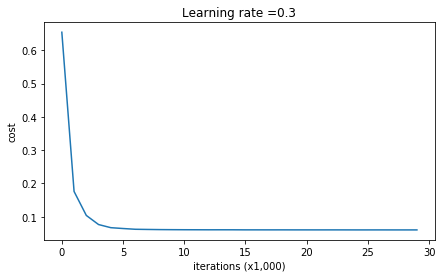

使用随机删除节点，训练集:
Accuracy: 0.9289099526066351
使用随机删除节点，测试集:
Accuracy: 0.95


In [20]:
parameters = model(train_X, train_Y, keep_prob=0.86, learning_rate=0.3,is_plot=True)

print("使用随机删除节点，训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("使用随机删除节点，测试集:")
reg_utils.predictions_test = reg_utils.predict(test_X, test_Y, parameters)

我们来看看它的分类情况：

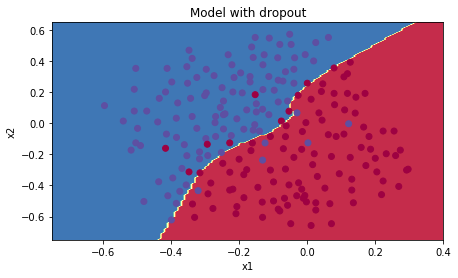

In [21]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, np.squeeze(train_Y))

# 六、结论：
**下面是3个模型的结果**: 

<table> 
    <tr>
        <td>
        **模型**
        </td>
        <td>
        **训练准确率**
        </td>
        <td>
        **测试准确率**
        </td>

   </tr>
        <td>
        无正则化的3层神经网络
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        带L2正则化的3层神经网络
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        带dropout的3层神经网络
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 

可以看到，正则化把训练集的准确度降低了，这是因为它限制了神经网络过拟合训练集的能力，但是因为测试集的准确度提高了，所以正则化对网络模型的训练是有帮助的。

结论：

1、正则化可以减小过拟合；

2、正则化会使权值更小；

3、L2和dropout是2种非常有效的正则化技术。